In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
train = pd.read_csv('train.csv')

FileNotFoundError: ignored

In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [ ]:
train.date

dtype('O')

In [ ]:
train = train[(train.store==1) & (train.item==1)]['sales'].to_numpy(dtype=float)
#train2 = train[(train.store==1) & (train.item==2)]['sales'].to_numpy(dtype=float)

In [ ]:
X_train, Y_train = [], []
window_size = 10
for i in range(len(train)-window_size):
  X_train.append(train[i:i+window_size])
  Y_train.append(train[i+window_size])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

array([12.,  6., 18., 19., 13., 16., 14., 19., 15., 27.])

In [ ]:
X_train[-1]

array([12.,  6., 18., 19., 13., 16., 14., 19., 15., 27.])

In [ ]:
Y_train[-1]

23.0

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train)

In [ ]:
dataset = dataset.window(5, shift=1, drop_remainder=True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(5))

In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
for x,y in dataset:
  print(x.numpy(), y.numpy())

[13. 11. 14. 13.] [10.]
[11. 14. 13. 10.] [12.]
[14. 13. 10. 12.] [10.]
[13. 10. 12. 10.] [9.]
[10. 12. 10.  9.] [12.]
[12. 10.  9. 12.] [9.]
[10.  9. 12.  9.] [9.]
[ 9. 12.  9.  9.] [7.]
[12.  9.  9.  7.] [10.]
[ 9.  9.  7. 10.] [12.]
[ 9.  7. 10. 12.] [5.]
[ 7. 10. 12.  5.] [7.]
[10. 12.  5.  7.] [16.]
[12.  5.  7. 16.] [7.]
[ 5.  7. 16.  7.] [18.]
[ 7. 16.  7. 18.] [15.]
[16.  7. 18. 15.] [8.]
[ 7. 18. 15.  8.] [7.]
[18. 15.  8.  7.] [9.]
[15.  8.  7.  9.] [8.]
[8. 7. 9. 8.] [14.]
[ 7.  9.  8. 14.] [12.]
[ 9.  8. 14. 12.] [12.]
[ 8. 14. 12. 12.] [11.]
[14. 12. 12. 11.] [6.]
[12. 12. 11.  6.] [9.]
[12. 11.  6.  9.] [13.]
[11.  6.  9. 13.] [11.]
[ 6.  9. 13. 11.] [21.]
[ 9. 13. 11. 21.] [15.]
[13. 11. 21. 15.] [14.]
[11. 21. 15. 14.] [9.]
[21. 15. 14.  9.] [10.]
[15. 14.  9. 10.] [13.]
[14.  9. 10. 13.] [11.]
[ 9. 10. 13. 11.] [14.]
[10. 13. 11. 14.] [11.]
[13. 11. 14. 11.] [16.]
[11. 14. 11. 16.] [11.]
[14. 11. 16. 11.] [14.]
[11. 16. 11. 14.] [10.]
[16. 11. 14. 10.] [11.]
[11. 14. 1

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TimeDataset(Dataset):
  def __init__(self, sequence_length, store, item):
    xy = pd.read_csv('train.csv')
    xy = xy[(xy.store==store) & (xy.item==item)]['sales'].to_numpy(dtype=float)
    self.x, self.y = [], []
    for i in range(len(xy)-sequence_length):
      self.x.append(xy[i:i+sequence_length])
      self.y.append(xy[i+sequence_length])
    self.x = torch.from_numpy(np.array(self.x)).float() #.unsqueeze()
    self.y = torch.from_numpy(np.array(self.y)).float() #.unsqueeze()
    self.n_samples = self.x.shape[0]

  def __getitem__(self, index):
    return self.x[index,:].unsqueeze(dim=-1), self.y[index].unsqueeze(dim=-1)

  def __len__(self):
    return self.n_samples

In [ ]:
input_size = 1
hidden_size = 50
hidden_size1 = 20
batch_size = 20
learning_rate = 0.001
sequence_length = 20
num_layers = 2
output_size = 1

In [ ]:
dataset = TimeDataset(sequence_length, 1, 1)

In [ ]:
dataset[-1][0].shape

torch.Size([20, 1])

In [ ]:
dataloader = DataLoader(dataset=dataset, batch_size =batch_size , shuffle=True, num_workers=2)

In [ ]:
dataloaderTest = DataLoader(dataset=dataset, batch_size =1 , shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(dataloader)

In [ ]:
data = dataiter.next()

In [ ]:
features, labels = data

In [ ]:
print(features.shape, labels.shape)

torch.Size([2, 10, 1]) torch.Size([2, 1])


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    #The input shape: batch_size, sequence_length, input_size (feature size)
    self.fc1 = nn.Linear(hidden_size,hidden_size1)
    self.fc = nn.Linear(hidden_size1,output_size)

  def forward(self, x):
      h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
      c0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
      #out,_ = self.rnn(x, h0)
      out,_ = self.rnn(x, (h0,c0))
      #The out shape: batch_size, sequence_length, hidden_size
      out = out[:,-1,:]
      out = self.fc1(out)
      out = self.fc(out)
      return out


In [ ]:
model = RNN(input_size, hidden_size, num_layers, output_size).to(device)

In [ ]:
model.forward(dataset[-1][0].unsqueeze(dim=0))

tensor([[0.8129]], grad_fn=<AddmmBackward>)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 50

In [ ]:
n_samples = len(dataset)

In [ ]:
n_iterations = np.ceil(n_samples/batch_size)

In [ ]:
for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(dataloader):
    outputs = model(inputs.to(device))
    loss = criterion(outputs, labels.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1)%20 == 0:
      print(f'epoch {epoch+1} / loss = {loss.item():.4f}')


epoch 1 / loss = 26.6432
epoch 1 / loss = 35.5276
epoch 1 / loss = 29.9168
epoch 1 / loss = 17.7895
epoch 2 / loss = 14.6831
epoch 2 / loss = 40.6129
epoch 2 / loss = 40.7458
epoch 2 / loss = 22.3828
epoch 3 / loss = 21.2798
epoch 3 / loss = 34.5543
epoch 3 / loss = 31.9874
epoch 3 / loss = 47.8567
epoch 4 / loss = 35.6519
epoch 4 / loss = 27.3474
epoch 4 / loss = 23.8295
epoch 4 / loss = 22.3809
epoch 5 / loss = 44.2888
epoch 5 / loss = 16.9188
epoch 5 / loss = 25.2179
epoch 5 / loss = 15.7063
epoch 6 / loss = 20.8231
epoch 6 / loss = 32.8949
epoch 6 / loss = 40.8438
epoch 6 / loss = 28.0677
epoch 7 / loss = 17.9603
epoch 7 / loss = 23.2239
epoch 7 / loss = 48.5065
epoch 7 / loss = 33.0989
epoch 8 / loss = 37.2810
epoch 8 / loss = 13.9403
epoch 8 / loss = 28.3877
epoch 8 / loss = 24.9354
epoch 9 / loss = 21.6983
epoch 9 / loss = 40.9110
epoch 9 / loss = 16.6723
epoch 9 / loss = 23.9539
epoch 10 / loss = 37.4017
epoch 10 / loss = 21.2261
epoch 10 / loss = 39.5473
epoch 10 / loss = 25.9

In [ ]:
preds = []
with torch.no_grad():
  for i, (inputs, labels) in enumerate(dataloaderTest):
    outputs = model(inputs.to(device)).to('cpu')
    preds.append(outputs.squeeze())

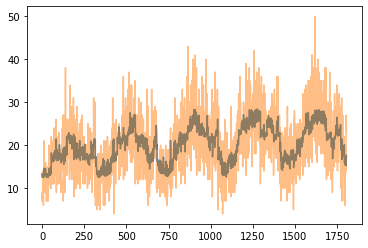

In [ ]:
plt.plot(preds)
plt.plot(dataset[:][1], alpha=0.5)